x_train shape: (152, 8)
RMSE_train: 20.704984290950772
R2_train: 0.9325582725721034
RMSE_test: 22.2860866733806
R2_test: 0.9169596313674162


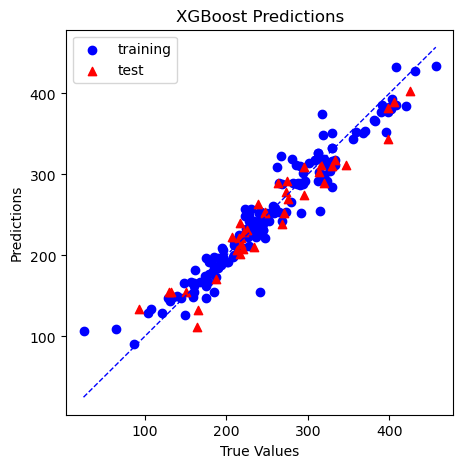

Generated virtual samples shape: (200, 8)
生成的虚拟样本（输入特征）：
 [[10.04280726  2.3254135   0.86442023 ...  0.18744801  0.22096275
   0.06378837]
 [ 9.50611893  2.61904198  0.88697746 ...  0.16440913  0.22162717
   0.12802961]
 [ 9.94343021  5.44865561  0.88982133 ...  0.16761615  0.
   0.03333664]
 ...
 [ 0.          7.80386526  0.88199395 ...  0.16536346  0.06862191
   0.        ]
 [ 3.48627102  0.          2.38968842 ...  0.24979994  0.03014136
   0.13172769]
 [21.6747196   3.04190703  2.32342071 ...  0.30777487  0.04155086
   0.        ]]
生成的虚拟样本（输出标签）：
 [339.29523  344.6775   351.85165  343.26675  339.29523  179.3414
 261.46393  211.85332  324.50385  315.77457  191.75163  181.93211
 344.7874   341.60284  343.33237  341.26764  286.70718  325.87177
 354.82404  192.007    108.138435 340.8248   343.31046  319.15646
 343.68323  175.0407   310.14865  323.51874  360.09818  344.35486
 108.138435 349.4296   202.00676  349.60666  128.39447  307.88452
 340.38867  351.3526   332.81268  329.53207  24

In [17]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import warnings
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb


warnings.filterwarnings("ignore")

# 读取数据
data = pd.read_excel('UTS.xlsx')

# 分割数据
X = data.iloc[:, 1:]
Y = data.iloc[:, 0]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=4)

# 数据归一化
scaler = MinMaxScaler()
x_train_normalized = scaler.fit_transform(x_train)

# 确保特征维度
print(f"x_train shape: {x_train.shape}")  # 输出训练集特征的形状

# 最佳参数
best_params = {
    'colsample_bytree': 1.0,
    'learning_rate': 0.1,
    'max_depth': 5,
    'min_child_weight': 5.411729501146951,
    'n_estimators': 139,
    'reg_alpha': 1.0,
    'reg_lambda': 1.0,
    'subsample': 0.5,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

# 使用最佳参数训练最终模型
xgb_model = xgb.XGBRegressor(**best_params)
xgb_model.fit(x_train, y_train)
# 评价模型
xgb_MSE = mean_squared_error(y_train, xgb_model.predict(x_train))
xgb_RMSE = np.sqrt(xgb_MSE)
xgb_R2 = r2_score(y_train, xgb_model.predict(x_train))
print('RMSE_train: ' + str(xgb_RMSE))
print('R2_train: ' + str(xgb_R2))

xgb_MSE_t = mean_squared_error(y_test, xgb_model.predict(x_test))
xgb_RMSE_t = np.sqrt(xgb_MSE_t)
xgb_R2_t = r2_score(y_test, xgb_model.predict(x_test))
print('RMSE_test: ' + str(xgb_RMSE_t))
print('R2_test: ' + str(xgb_R2_t))


# 可视化结果
plt.figure(figsize=(5, 5))
plt.scatter(y_train, xgb_model.predict(x_train), c="blue", label='training')
plt.scatter(y_test, xgb_model.predict(x_test), c='red', label='test', marker='^')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'b--', lw=1)
plt.legend()
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('XGBoost Predictions')
plt.show()

# 计算样本集中值
def compute_central_location(X):
    return np.mean(X, axis=0)

# 计算左右偏度
def compute_skewness(X, CL):
    N_L = np.sum(X < CL, axis=0)
    N_U = np.sum(X > CL, axis=0)
    skewness_L = N_L / (N_L + N_U + 1)
    skewness_U = N_U / (N_L + N_U + 1)
    return skewness_L, skewness_U

# 计算不对称接受域范围
def compute_asymmetric_range(X, CL, skewness_L, skewness_U):
    LB = CL - (1 / skewness_U) * (CL - np.min(X, axis=0))
    UB = CL + (1 / skewness_L) * (np.max(X, axis=0) - CL)
    return LB, UB

# PSO算法生成虚拟输入特征
def generate_virtual_samples(X, num_samples=100, num_particles=30, num_iterations=100):
    CL = compute_central_location(X)
    skewness_L, skewness_U = compute_skewness(X, CL)
    LB, UB = compute_asymmetric_range(X, CL, skewness_L, skewness_U)
    
    all_samples = []
    
    while len(all_samples) < num_samples:
        particles = np.random.uniform(LB, UB, (num_particles, X.shape[1]))
        velocities = np.zeros_like(particles)
        personal_best = particles.copy()
        global_best = particles[np.argmin(np.std(particles, axis=1))]

        for _ in range(num_iterations):
            r1, r2 = np.random.rand(), np.random.rand()
            velocities = 0.7 * velocities + 1.5 * r1 * (personal_best - particles) + 1.5 * r2 * (global_best - particles)
            particles = particles + velocities
            particles = np.clip(particles, LB, UB)
            particles = np.clip(particles, 0, None)  # 确保所有特征值为正
            
            current_best = particles[np.argmin(np.std(particles, axis=1))]
            if np.std(current_best) < np.std(global_best):
                global_best = current_best

        for particle in particles:
            if len(all_samples) < num_samples and not any(np.array_equal(particle, s) for s in all_samples):
                all_samples.append(particle)
    
    virtual_samples = np.array(all_samples)
    print(f"Generated virtual samples shape: {virtual_samples.shape}")  # 迭代信息
    return virtual_samples

# 生成虚拟输入特征
virtual_features_normalized = generate_virtual_samples(x_train_normalized, num_samples=200)

# 反归一化处理
virtual_features = scaler.inverse_transform(virtual_features_normalized)

# 确保虚拟输入特征的形状与训练集特征形状一致
assert virtual_features.shape[1] == x_train.shape[1], 

# 预测虚拟样本的输出标签
virtual_labels = xgb_model.predict(virtual_features)

# 应用Z-Score异常值检测
z_scores = np.abs(stats.zscore(virtual_features, axis=0))
outliers = (z_scores > 3).any(axis=1)
virtual_features_filtered = virtual_features[~outliers]
virtual_labels_filtered = virtual_labels[~outliers]

# 打印生成的虚拟样本
print("生成的虚拟样本（输入特征）：\n", virtual_features_filtered)
print("生成的虚拟样本（输出标签）：\n", virtual_labels_filtered)

# 将虚拟样本数据导出到Excel
virtual_data = pd.DataFrame(virtual_features_filtered, columns=X.columns)
virtual_data['Predicted_Output'] = virtual_labels_filtered
virtual_data.to_excel('uts_virtual_samples_filtered.xlsx', index=False)
print("虚拟样本数据已导出到 uts_virtual_samples_filtered.xlsx")


In [18]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

# 读取数据
data = pd.read_excel('uts_virtual_samples_filtered.xlsx')

# 数据归一化
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)

# 将归一化数据转换为DataFrame
data_normalized_df = pd.DataFrame(data_normalized, columns=data.columns)

# 将归一化数据导出为Excel文件
data_normalized_df.to_excel('UTS_kuo_normalized200.xlsx', index=False)

print("Normalized data has been saved to 'UTS_normalized.xlsx'.")


Normalized data has been saved to 'UTS_normalized.xlsx'.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

import xgboost as xgb
import shap

# 读取数据
data = pd.read_excel('UTS_normalized.xlsx')


# 分割数据
X = data.iloc[:, 1:]
Y = data.iloc[:, 0]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=4)



# 最佳参数
best_params = {
    'colsample_bytree': 1.0,
    'learning_rate': 0.1,
    'max_depth': 5,
    'min_child_weight': 5.411729501146951,
    'n_estimators': 139,
    'reg_alpha': 1.0,
    'reg_lambda': 1.0,
    'subsample': 0.5,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

# 使用最佳参数训练最终模型
xgb_model = xgb.XGBRegressor(**best_params)
xgb_model.fit(x_train, y_train)

# 计算SHAP值
explainer = shap.Explainer(xgb_model)
shap_values = explainer(x_test)

# 初始化JavaScript库
shap.initjs()

# 特征重要性排序柱状图
shap.plots.bar(shap_values)

# 使用Matplotlib绘制SHAP力图，手动增加显示特征
plt.figure()
shap_values_sample = shap_values[0]  # 选择第一个样本
feature_importance = np.abs(shap_values_sample.values).argsort()[::-1]  # 按照重要性排序特征
top_features = feature_importance[:8]  # 输出8个特征

shap.force_plot(explainer.expected_value, shap_values_sample.values[top_features], x_test.iloc[0, top_features], matplotlib=True)
plt.show()

# SHAP值summary plot
shap.summary_plot(shap_values, x_test, plot_type="bar")

# SHAP summary plot with distribution
shap.summary_plot(shap_values, x_test)